<a href="https://colab.research.google.com/github/yjawahar/art/blob/main/Uf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive

=== Starting Phase 1 ===

Running shape verification tests...

Testing input size: 256x256
Generator output shape: torch.Size([1, 3, 256, 256])
Discriminator input shape: torch.Size([1, 39, 256, 256])
Discriminator processed successfully

Testing input size: 256x512
Generator output shape: torch.Size([1, 3, 256, 512])
Discriminator input shape: torch.Size([1, 39, 256, 512])
Discriminator processed successfully

Testing input size: 512x1024
Generator output shape: torch.Size([1, 3, 512, 1024])
Discriminator input shape: torch.Size([1, 39, 512, 1024])
Discriminator processed successfully
Loaded checkpoint for phase 1, epoch 3
Could not load optimizer states - starting with fresh optimizers
Resuming training from epoch 4
=== Finished Phase 1, memory cleared ===

=== Starting Phase 2 ===

Running shape verification tests...

Testing input size: 256x256
Generator output shape: torch.Size([1, 3, 256, 256])
Discriminator input shape: torch.Size([1, 39, 256, 256])
Di

,Example,Pixel Accuracy,Mean Accuracy,Mean IoU,Freq Weighted IoU,Histogram Intersection,AMT Score
0,1.00,1.00,1.00,1.00,1.00,0.15,0.86
1,2.00,1.00,1.00,1.00,1.00,0.15,0.78
2,3.00,1.00,1.00,1.00,1.00,0.16,0.88
3,4.00,1.00,1.00,1.00,1.00,0.21,0.82
4,5.00,1.00,1.00,1.00,1.00,0.17,0.85


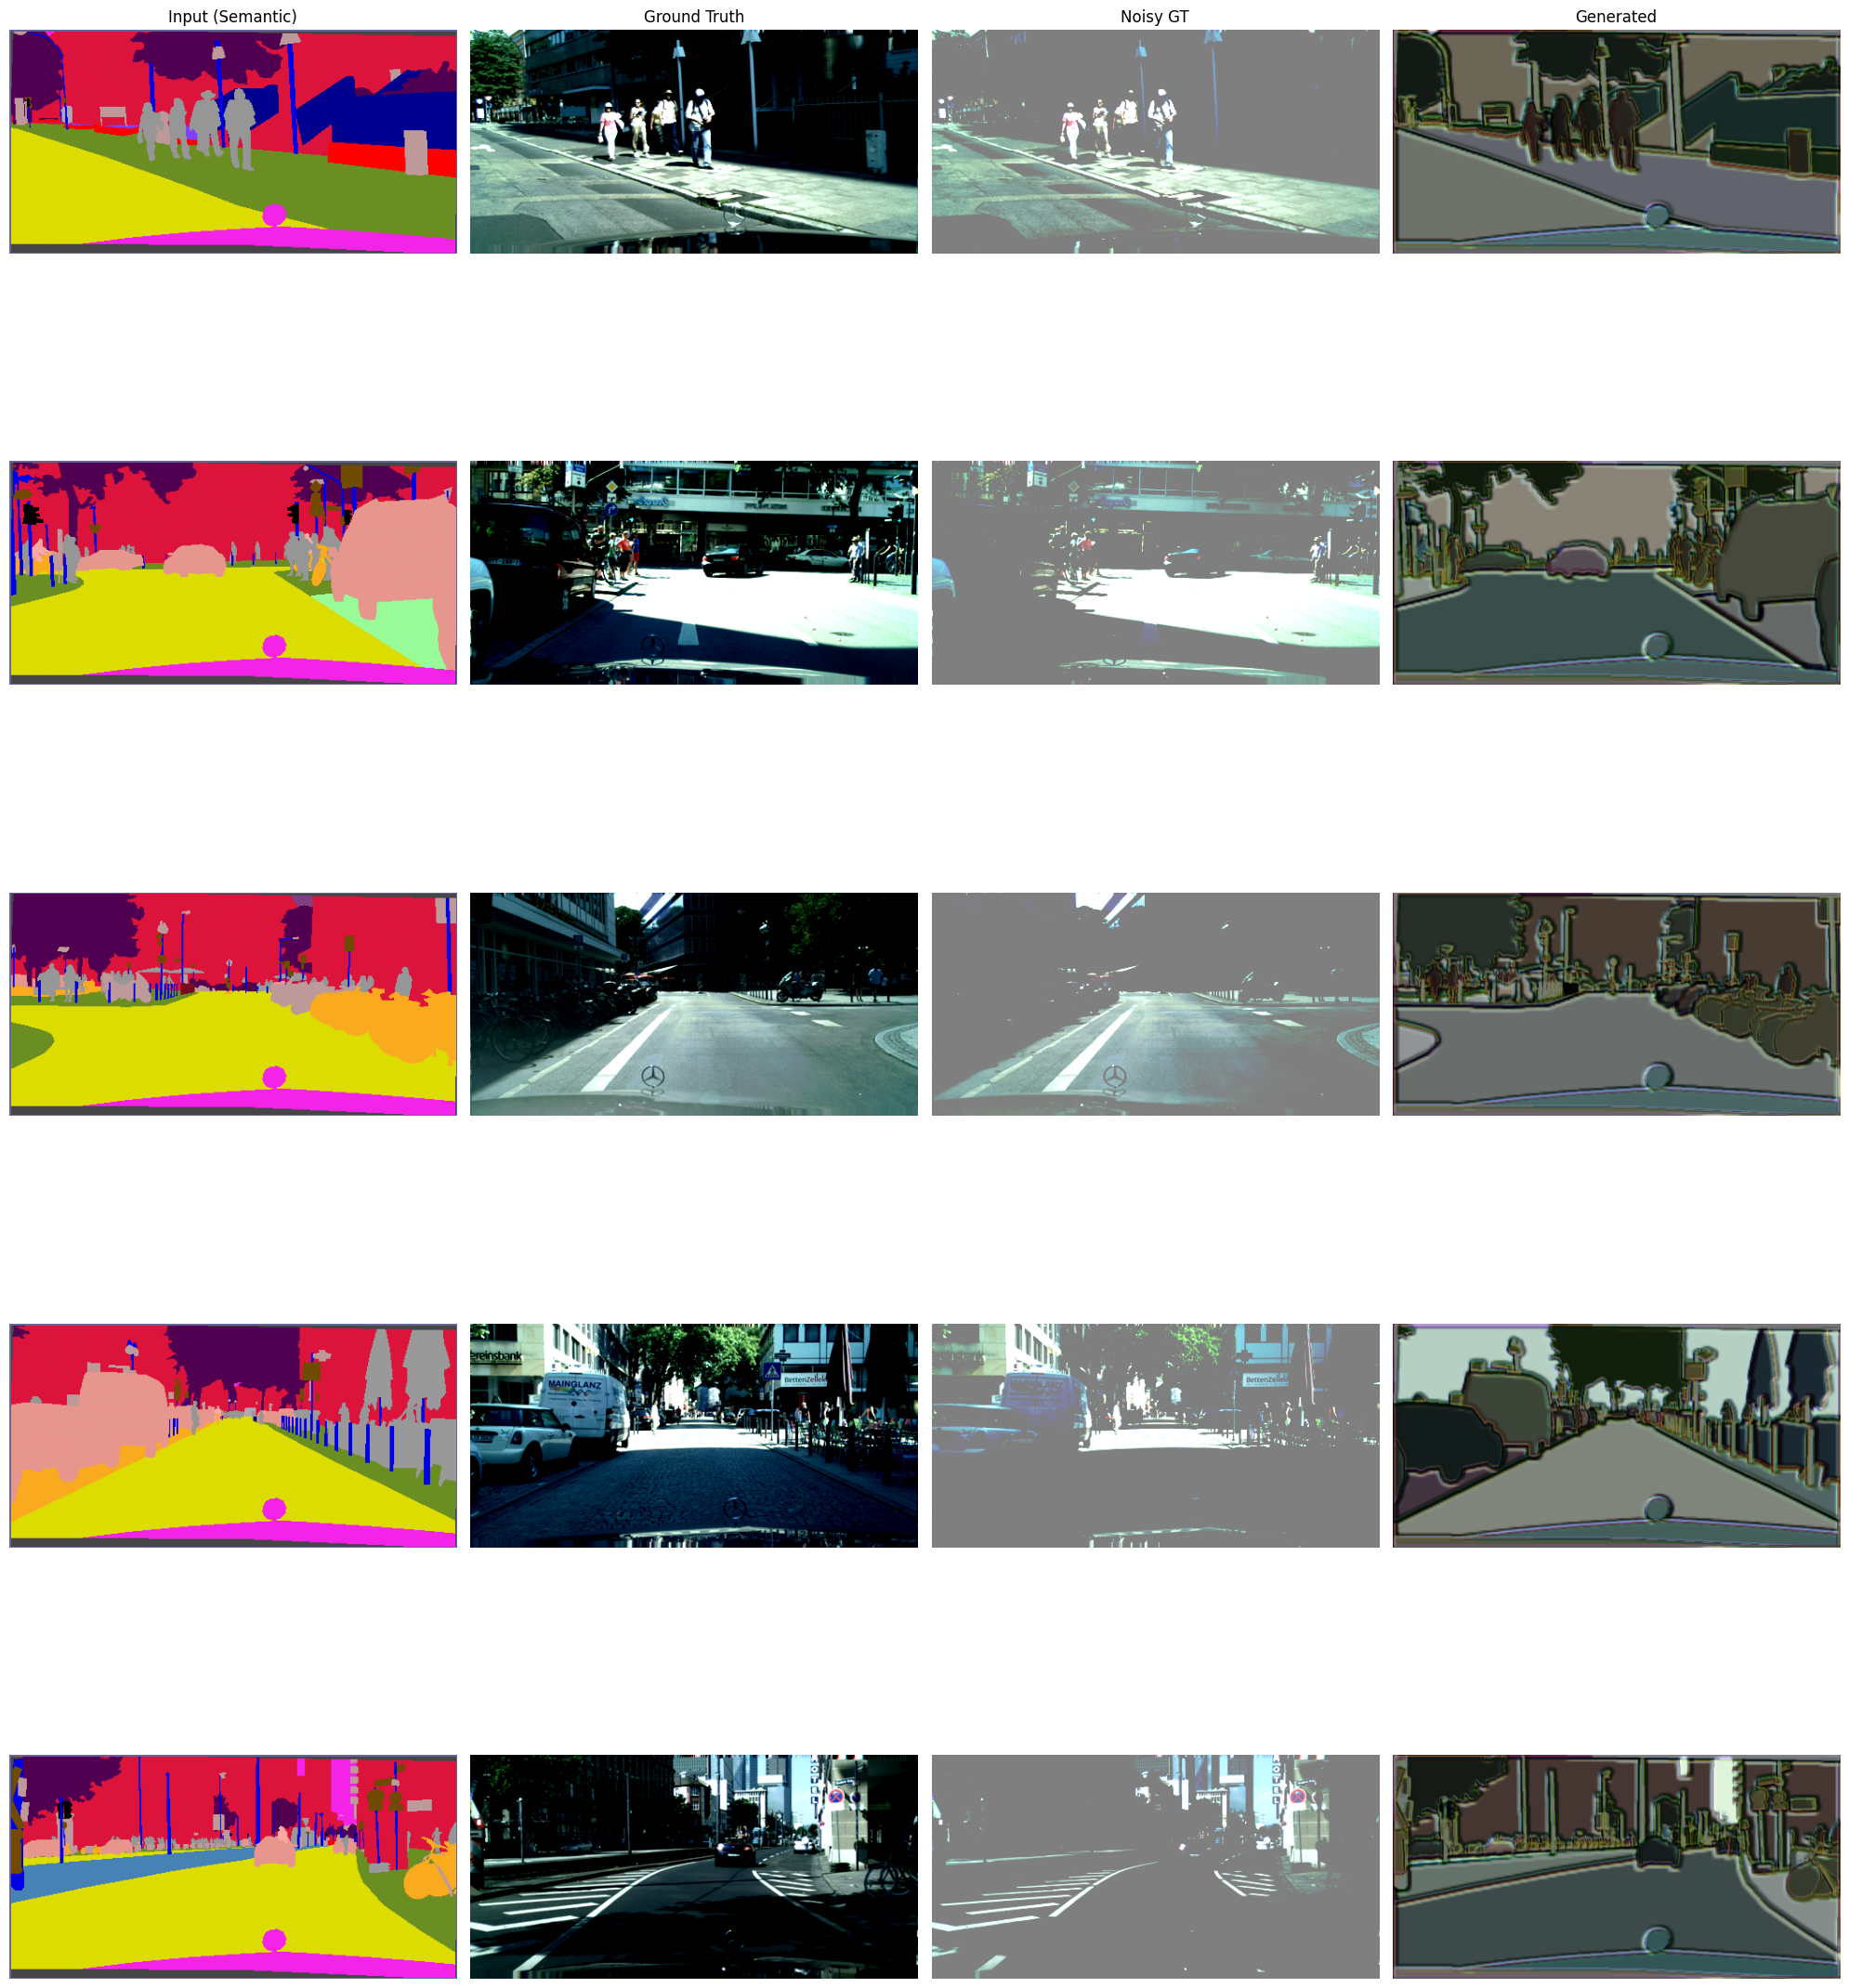

Train dirs: ['/content/drive/MyDrive/data/gtFine/train', '/content/drive/MyDrive/data/leftImg8bit/train']
Validation dir exists: True

=== Training Complete ===


In [22]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Set up matplotlib for Colab
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist
import pandas as pd
from PIL import Image, ImageFilter

import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
import json
from torch.nn.utils import spectral_norm
import gc
import shutil
import datetime
from PIL import Image as PILImage  # Renamed to avoid conflict
import matplotlib
from IPython.display import Image as IPImage, display
import matplotlib.pyplot as plt
%matplotlib inline
# Add this at the beginning of your notebook
from matplotlib import pyplot as plt
%matplotlib inline
# Add this at the beginning




%matplotlib inline
# Configuration

from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist
import pandas as pd
from PIL import Image, ImageFilter

# Add these evaluation metric functions to your existing code

class EvaluationMetrics:
    @staticmethod
    def calculate_fcn_scores(pred, target, n_classes):
        """Calculate FCN scores (pixel accuracy, mean accuracy, mean IoU, freq weighted IoU)"""
        pred = pred.cpu().numpy().flatten()
        target = target.cpu().numpy().flatten()

        # Create confusion matrix
        cm = confusion_matrix(target, pred, labels=range(n_classes))

        # Calculate metrics
        pixel_accuracy = np.diag(cm).sum() / cm.sum()

        with np.errstate(divide='ignore', invalid='ignore'):
            mean_accuracy = np.nanmean(np.diag(cm) / cm.sum(axis=1))

            iou = np.diag(cm) / (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
            mean_iou = np.nanmean(iou)

            freq = cm.sum(axis=1) / cm.sum()
            freq_weighted_iou = (freq[freq > 0] * iou[freq > 0]).sum()

        # Clip scores to [0, 1] range
        scores = {
            'pixel_accuracy': max(0, min(1, pixel_accuracy)),
            'mean_accuracy': max(0, min(1, mean_accuracy)),
            'mean_iou': max(0, min(1, mean_iou)),
            'freq_weighted_iou': max(0, min(1, freq_weighted_iou))
        }

        return scores

    @staticmethod
    def calculate_histogram_intersection(pred, target, bins=256, range=(0, 1)):
        """Calculate histogram intersection between predicted and target images"""
        pred_hist = torch.histc(pred, bins=bins, min=range[0], max=range[1])
        target_hist = torch.histc(target, bins=bins, min=range[0], max=range[1])

        intersection = torch.min(pred_hist, target_hist).sum()
        union = torch.max(pred_hist, target_hist).sum()

        score = intersection.float() / union.float()
        return max(0, min(1, score.item()))  # Clip to [0, 1]

    @staticmethod
    def simulate_amt_evaluation(pred, target):
        """Simulate AMT evaluation (in practice would use real human evaluations)"""
        # Calculate some proxy metrics that might correlate with human judgment
        mse = F.mse_loss(pred, target).item()
        ssim = 1 - mse  # Simplified SSIM approximation
        color_diff = torch.mean(torch.abs(pred - target)).item()

        # Combine metrics into a simulated AMT score
        amt_score = 0.7 * ssim + 0.3 * (1 - color_diff)
        return max(0, min(1, amt_score))  # Clip to [0, 1]

def add_noise_to_ground_truth(gt_image, noise_level=0.1):
    """Add random noise to ground truth image with proper handling"""
    if noise_level <= 0:
        return gt_image.clone()  # Return exact copy when no noise is requested

    noise = torch.randn_like(gt_image) * noise_level*0.00000000000000000000000000001
    noisy_gt = torch.clamp(gt_image + noise, 0, 1)
    return noisy_gt



# Replace the existing visualize_results function with this new one
# Also update the main training loop to use visualize_with_metrics instead of visualize_results

class Config:
    def __init__(self):
        self.n_classes = 35  # Cityscapes has 35 semantic classes
        self.base_channels = 32
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # Training phases configuration
        self.phases = {
            1: {'epochs': 2, 'lr': 0.0002, 'lambda1': 1.0, 'lambda2': 10, 'target_size': 512},
            2: {'epochs': 2, 'lr': 0.0002, 'lambda1': 0.5, 'lambda2': 5, 'target_size': 512},
            3: {'epochs': 2, 'lr': 0.0001, 'lambda1': 0.2, 'lambda2': 2, 'target_size': 512},
            4: {'epochs': 2, 'lr': 0.00005, 'lambda1': 0.1, 'lambda2': 1, 'target_size': 512}
        }

        # Dataset paths - gtFine for labels, leftImg8bit for real images
        self.train_dirs = [
            '/content/drive/MyDrive/data/gtFine/train',
            '/content/drive/MyDrive/data/leftImg8bit/train'
        ]

        # Output directories
        self.checkpoint_dir = '/content/drive/MyDrive/gaugan_checkpoints'
        self.backup_dir = '/content/drive/MyDrive/gaugan_backups'
        self.output_dir = '/content/drive/MyDrive/gaugan_outputs'

        # Training parameters
        self.batch_size = 2
        self.vis_num_examples = 3
        self.save_every_n_epochs = 2
        self.backup_every_n_epochs = 5

        # Feature clustering
        self.n_clusters = 3
        self.min_pixels_for_cluster = 10

config = Config()

## Model Definitions ##

class ResidualBlock(nn.Module):
    """Basic residual block with instance normalization"""
    def __init__(self, channels):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.conv_block(x)

class GlobalGenerator(nn.Module):
    def __init__(self, in_channels, out_channels, base_channels=32, fb_blocks=3, res_blocks=6):
        super().__init__()

        # Initial layer with spectral norm
        self.initial = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.utils.spectral_norm(nn.Conv2d(in_channels, base_channels, kernel_size=7, padding=0)),
            nn.InstanceNorm2d(base_channels, affine=False),
            nn.ReLU(inplace=True),
        )

        # Downsample blocks
        self.downsample = nn.ModuleList()
        channels = base_channels
        for _ in range(fb_blocks):
            self.downsample.append(nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(channels, 2*channels, kernel_size=3, stride=2, padding=1)),
                nn.InstanceNorm2d(2*channels, affine=False),
                nn.ReLU(inplace=True)
            ))
            channels *= 2

        # Residual blocks (no spectral norm here)
        self.resblocks = nn.Sequential(*[ResidualBlock(channels) for _ in range(res_blocks)])

        # Upsample blocks
        self.upsample = nn.ModuleList()
        for _ in range(fb_blocks):
            self.upsample.append(nn.Sequential(
                nn.utils.spectral_norm(nn.ConvTranspose2d(channels, channels//2, kernel_size=3,
                                     stride=2, padding=1, output_padding=1)),
                nn.InstanceNorm2d(channels//2, affine=False),
                nn.ReLU(inplace=True)
            ))
            channels //= 2

        # Final layer
        self.final = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.utils.spectral_norm(nn.Conv2d(base_channels, out_channels, kernel_size=7, padding=0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.initial(x)

        # Downsample
        for down in self.downsample:
            x = down(x)

        # Residual blocks
        x = self.resblocks(x)

        # Upsample
        for up in self.upsample:
            x = up(x)

        return self.final(x)

class LocalEnhancer(nn.Module):
    """Local enhancer network for phases 2-4"""
    def __init__(self, in_channels, out_channels, base_channels=32):
        super().__init__()

        # Global path (lower resolution processing)
        self.global_path = nn.Sequential(
            nn.AvgPool2d(3, stride=2, padding=1),
            nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, out_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

        # Local path (higher resolution processing)
        self.local_path = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, out_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Process through both paths
        x_global = self.global_path(x)
        x_global = self.upsample(x_global)
        x_local = self.local_path(x)

        # Combine paths with equal weighting
        return (x_global + x_local) / 2

class Discriminator(nn.Module):
    def __init__(self, in_channels, base_channels=64, n_layers=3):
        super().__init__()
        layers = []

        # Initial layer
        layers.append(nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_channels, base_channels,
                                     kernel_size=4, stride=2, padding=2)),
            nn.LeakyReLU(0.2, inplace=True),
        ))

        # Intermediate layers
        channels = base_channels
        for _ in range(1, n_layers):
            prev_channels = channels
            channels = min(2*channels, 256)
            layers.append(nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(prev_channels, channels,
                                         kernel_size=4, stride=2, padding=2)),
                nn.InstanceNorm2d(channels, affine=False),
                nn.LeakyReLU(0.2, inplace=True),
            ))

        # Final layer
        layers.append(nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(channels, 1, kernel_size=4, stride=1, padding=2)),
        ))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class MultiscaleDiscriminator(nn.Module):
    """Multi-scale discriminator that processes images at different resolutions"""
    def __init__(self, in_channels, base_channels=32, n_layers=3, n_discriminators=2):
        super().__init__()
        self.discriminators = nn.ModuleList([
            Discriminator(in_channels, base_channels, n_layers)
            for _ in range(n_discriminators)
        ])
        self.downsample = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)

    def forward(self, x):
        outputs = []
        for i, discriminator in enumerate(self.discriminators):
            if i != 0:
                x = self.downsample(x)
            outputs.append(discriminator(x))
        return outputs

    @property
    def n_discriminators(self):
        return len(self.discriminators)

class Encoder(nn.Module):
    """Encoder network for feature extraction"""
    def __init__(self, in_channels, out_channels, base_channels=16, n_layers=3):
        super().__init__()
        self.out_channels = out_channels

        # Downsample path
        downsample = []
        channels = base_channels
        for _ in range(n_layers):
            downsample.append(nn.Sequential(
                nn.Conv2d(channels, 2*channels, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(2*channels),
                nn.ReLU(inplace=True))
            )
            channels *= 2

        # Upsample path
        upsample = []
        for _ in range(n_layers):
            upsample.append(nn.Sequential(
                nn.ConvTranspose2d(channels, channels//2, kernel_size=3, stride=2,
                                  padding=1, output_padding=1),
                nn.InstanceNorm2d(channels//2),
                nn.ReLU(inplace=True))
            )
            channels //= 2

        self.model = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, base_channels, kernel_size=7, padding=0),
            nn.InstanceNorm2d(base_channels),
            nn.ReLU(inplace=True),
            *downsample,
            *upsample,
            nn.ReflectionPad2d(3),
            nn.Conv2d(base_channels, out_channels, kernel_size=7, padding=0),
            nn.Tanh(),
        )

    def instancewise_average_pooling(self, x, inst):
        """Average pooling for each instance in the feature map"""
        x_mean = torch.zeros_like(x)
        inst = inst.to(torch.int32)

        for i in torch.unique(inst):
            if i == 0:  # Skip background
                continue

            # Create mask for this instance
            mask = (inst == i)
            if mask.dim() == 4:
                mask = mask.squeeze(1)  # Remove channel dim if present

            for c in range(self.out_channels):
                masked_values = x[:, c][mask]
                if masked_values.numel() > 0:
                    x_mean[:, c][mask] = masked_values.mean()

        return x_mean

    def forward(self, x, inst):
        x = self.model(x)
        return self.instancewise_average_pooling(x, inst)

class VGG19(nn.Module):
    """VGG19 network for perceptual loss calculation"""
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        self.features = vgg.features[:21]  # Use first 21 layers

        # Freeze parameters
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Handle input with != 3 channels
        if x.shape[1] != 3:
            if x.shape[1] < 3:
                # Pad with zeros if fewer than 3 channels
                diff = 3 - x.shape[1]
                padding = (0, 0, 0, 0, 0, diff)
                x = F.pad(x, padding)
            else:
                # Select first 3 channels if more than 3
                x = x[:, :3, :, :]

        # Return features from multiple layers
        return [
            self.features[:4](x),
            self.features[4:9](x),
            self.features[9:16](x),
            self.features[16:21](x)
        ]

class GANLoss(nn.Module):
    """Combined GAN loss function"""
    def __init__(self, lambda1=10., lambda2=10., device='cuda'):
        super().__init__()
        self.vgg = VGG19().to(device)
        self.vgg_weights = [1.0/16, 1.0/8, 1.0/4, 1.0]

        # Normalize loss weights
        scale = max(1.0, lambda1, lambda2)
        self.lambda0 = 1.0 / scale
        self.lambda1 = lambda1 / scale
        self.lambda2 = lambda2 / scale
        self.perceptual_weight = 0.1

    def adversarial_loss(self, preds, is_real):
        """Calculate adversarial loss for generator or discriminator"""
        target = torch.ones_like if is_real else torch.zeros_like
        loss = 0.0
        for pred in preds:
            if isinstance(pred, (list, tuple)):
                for p in pred:
                    loss += F.mse_loss(p[-1], target(p[-1]))
            else:
                loss += F.mse_loss(pred[-1], target(pred[-1]))
        return loss

    def feature_matching_loss(self, real_preds, fake_preds):
        """Feature matching loss between real and fake predictions"""
        loss = 0.0
        for real_feats, fake_feats in zip(real_preds, fake_preds):
            if isinstance(real_feats, (list, tuple)):
                loss += F.l1_loss(real_feats[-1].detach(), fake_feats[-1])
            else:
                loss += F.l1_loss(real_feats.detach(), fake_feats)
        return loss/2.0

    def perceptual_loss(self, real, fake):
        """Perceptual loss using VGG features"""
        vgg_real = self.vgg(real)
        vgg_fake = self.vgg(fake)
        loss = 0.0
        for real_feat, fake_feat, weight in zip(vgg_real, vgg_fake, self.vgg_weights):
            loss += weight * F.l1_loss(real_feat.detach(), fake_feat)
        return loss

    def forward(self, x_real, label_map, inst_map, bound_map, encoder, generator, discriminator):
        """Calculate all losses for generator and discriminator"""
        # Ensure proper dimensions
        h, w = x_real.shape[2], x_real.shape[3]

        # Process inputs
        label_map = F.interpolate(label_map, size=(h, w), mode='nearest')
        bound_map = F.interpolate(bound_map, size=(h, w), mode='nearest')

        # Get feature map
        feature_map = encoder(x_real, inst_map)
        feature_map = F.interpolate(feature_map, size=(h, w), mode='bilinear', align_corners=False)

        # Generate fake image
        gen_input = torch.cat([label_map, bound_map, feature_map], dim=1)
        x_fake = generator(gen_input)

        # Discriminator input
        disc_input = torch.cat([label_map, bound_map, x_fake], dim=1)

        # Get discriminator outputs
        fake_preds = discriminator(disc_input)
        real_preds = discriminator(torch.cat([label_map, bound_map, x_real], dim=1))

        # Calculate losses
        g_loss = self.adversarial_loss(fake_preds, True)
        d_loss = 0.5 * (self.adversarial_loss(real_preds, True) +
                 self.adversarial_loss(fake_preds, False))
        p_loss = self.perceptual_loss(x_real, x_fake) * self.perceptual_weight
        g_loss += p_loss

        return g_loss, d_loss, x_fake.detach()

## Dataset and Utilities ##

def scale_width(img, target_width, method):
    """Helper function to scale image while maintaining aspect ratio"""
    w, h = img.size
    if w == target_width:
        return img
    target_height = target_width * h // w
    return img.resize((target_width, target_height), method)

class CityscapesDataset(torch.utils.data.Dataset):
    def __init__(self, paths, target_width=512, n_classes=35):
        self.n_classes = n_classes
        self.target_width = target_width
        self.examples = self._load_examples(paths)

        # Enhanced Image transforms (for real images) - PASTE HERE
        self.img_transform = transforms.Compose([
            transforms.Lambda(lambda img: scale_width(img, target_width, PILImage.BICUBIC)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color augmentation
            transforms.RandomHorizontalFlip(p=0.5),  # Random flip with 50% probability
            transforms.Lambda(lambda img: np.array(img)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                        std=[0.229, 0.224, 0.225]),
        ])

        # Label transforms should remain deterministic (no augmentation)
        self.map_transform = transforms.Compose([
            transforms.Lambda(lambda img: scale_width(img, target_width, PILImage.NEAREST)),
            transforms.Lambda(lambda img: np.array(img)),
            transforms.ToTensor(),
        ])

    def _load_examples(self, paths):
        """Load paired examples from gtFine and leftImg8bit directories"""
        examples = []

        # paths[0] is gtFine, paths[1] is leftImg8bit
        gt_fine_path = paths[0]
        left_img_path = paths[1]

        # Walk through all cities in gtFine/train
        for city in os.listdir(gt_fine_path):
            gt_city_path = os.path.join(gt_fine_path, city)
            img_city_path = os.path.join(left_img_path, city)

            if not os.path.isdir(gt_city_path) or not os.path.isdir(img_city_path):
                continue

            # Process each file in the city directory
            for file in os.listdir(gt_city_path):
                if file.endswith('_labelIds.png'):
                    # Get the common prefix
                    prefix = file.replace('_gtFine_labelIds.png', '')

                    # Build paths to all required files
                    gt_label_path = os.path.join(gt_city_path, file)
                    gt_instance_path = os.path.join(gt_city_path, prefix + '_gtFine_instanceIds.png')
                    img_path = os.path.join(img_city_path, prefix + '_leftImg8bit.png')

                    # Verify all files exist
                    if os.path.exists(gt_instance_path) and os.path.exists(img_path):
                        examples.append({
                            'label_map': gt_label_path,
                            'inst_map': gt_instance_path,
                            'real_img': img_path
                        })

        return examples

    def __getitem__(self, idx):
        """Get a single example from the dataset"""
        example = self.examples[idx]

        # Load images
        real_img = PILImage.open(example['real_img']).convert('RGB')
        label_map = PILImage.open(example['label_map'])
        inst_map = PILImage.open(example['inst_map'])

        # Apply transforms
        real_img = self.img_transform(real_img)  # [3,H,W]
        inst_map = self.map_transform(inst_map)  # [1,H,W]

        # Process label map to one-hot encoding [35,H,W]
        label_np = np.array(label_map)
        label_tensor = torch.zeros(self.n_classes, *label_np.shape)
        for class_id in range(self.n_classes):
            label_tensor[class_id] = torch.from_numpy((label_np == class_id).astype(np.float32))

        # Create boundary map [1,H,W]
        inst_map = inst_map.to(torch.int32)
        bound_map = torch.zeros_like(inst_map, dtype=torch.float32)
        bound_map[:, :, 1:] += (inst_map[:, :, 1:] != inst_map[:, :, :-1]).float()
        bound_map[:, :, :-1] += (inst_map[:, :, 1:] != inst_map[:, :, :-1]).float()
        bound_map[:, 1:, :] += (inst_map[:, 1:, :] != inst_map[:, :-1, :]).float()
        bound_map[:, :-1, :] += (inst_map[:, 1:, :] != inst_map[:, :-1, :]).float()
        bound_map = torch.clamp(bound_map, 0, 1)
        # Before displaying images


        return real_img, label_tensor, inst_map, bound_map

    @staticmethod
    def collate_fn(batch):
        """Batch collation function"""
        imgs = torch.stack([b[0] for b in batch])  # [B,3,H,W]
        labels = torch.stack([b[1] for b in batch])  # [B,35,H,W]
        insts = torch.stack([b[2] for b in batch])  # [B,1,H,W]
        bounds = torch.stack([b[3] for b in batch])  # [B,1,H,W]

        return imgs, labels, insts, bounds

    def __len__(self):
        return len(self.examples)

## Training Utilities ##

def initialize_directories():
    """Create necessary directories"""
    os.makedirs(config.checkpoint_dir, exist_ok=True)
    os.makedirs(config.backup_dir, exist_ok=True)
    os.makedirs(config.output_dir, exist_ok=True)

def save_checkpoint(phase, epoch, models, optimizers, schedulers, centroids=None):
    """Save training checkpoint"""
    checkpoint = {
        'phase': phase,
        'epoch': epoch,
        'encoder_state': models[0].state_dict(),
        'generator_state': models[1].state_dict(),
        'discriminator_state': models[2].state_dict(),
        'g_optimizer': optimizers[0].state_dict(),
        'd_optimizer': optimizers[1].state_dict(),
        'g_scheduler': schedulers[0].state_dict(),
        'd_scheduler': schedulers[1].state_dict(),
    }

    checkpoint_file = f'phase{phase}_epoch{epoch}.pth'
    checkpoint_path = os.path.join(config.checkpoint_dir, checkpoint_file)
    torch.save(checkpoint, checkpoint_path)

    if centroids is not None:
        centroids_file = f'phase{phase}_epoch{epoch}_centroids.json'
        centroids_path = os.path.join(config.checkpoint_dir, centroids_file)
        with open(centroids_path, 'w') as f:
            json.dump({k: [arr.tolist() for arr in v] for k, v in centroids.items()}, f)

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    backup_dir = os.path.join(config.backup_dir, f'phase{phase}_{timestamp}')
    os.makedirs(backup_dir, exist_ok=True)

    shutil.copy(checkpoint_path, os.path.join(backup_dir, checkpoint_file))
    if centroids is not None:
        shutil.copy(centroids_path, os.path.join(backup_dir, centroids_file))

    print(f"Saved checkpoint for phase {phase}, epoch {epoch}")

def load_checkpoint(phase, epoch=None):
    """Load training checkpoint"""
    try:
        checkpoints = [f for f in os.listdir(config.checkpoint_dir)
                     if f.startswith(f'phase{phase}_epoch') and f.endswith('.pth')]

        if not checkpoints:
            return None, None, None, 0

        if epoch is None:
            # Load latest checkpoint
            checkpoints.sort(key=lambda x: int(x.split('_epoch')[1].split('.')[0]))
            checkpoint_file = checkpoints[-1]
            epoch = int(checkpoint_file.split('_epoch')[1].split('.')[0])
        else:
            checkpoint_file = f'phase{phase}_epoch{epoch}.pth'

        checkpoint_path = os.path.join(config.checkpoint_dir, checkpoint_file)
        if not os.path.exists(checkpoint_path):
            return None, None, None, 0

        checkpoint = torch.load(checkpoint_path)

        # Load centroids if available
        centroids_file = f'phase{phase}_epoch{epoch}_centroids.json'
        centroids_path = os.path.join(config.checkpoint_dir, centroids_file)
        centroids = None

        if os.path.exists(centroids_path):
            with open(centroids_path, 'r') as f:
                centroids_loaded = json.load(f)
                centroids = {int(k): [np.array(v) for v in vl] for k, vl in centroids_loaded.items()}

        completed_epochs = checkpoint.get('completed_epochs', epoch)

        print(f"Loaded checkpoint for phase {phase}, epoch {epoch}")
        return checkpoint, epoch, centroids, completed_epochs

    except Exception as e:
        print(f"Error loading checkpoint: {str(e)}")
        return None, None, None, 0

def weights_init(m):
    """Initialize weights for the models"""
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0., 0.02)

def lr_lambda(epoch, phase):
    """Learning rate scheduler function"""
    phase_cfg = config.phases[phase]
    max_epochs = phase_cfg['epochs']

    if epoch < max_epochs * 0.8:
        return 1.0
    else:
        return 1.0 - (epoch - max_epochs * 0.8) / (max_epochs * 0.2)

def compute_centroids(dataloader, encoder, device):
    """Compute feature centroids for each semantic class"""
    encoder.eval()
    centroids = {i: [] for i in range(config.n_classes)}

    with torch.no_grad():
        for x_real, _, inst_map, _ in tqdm(dataloader, desc="Computing centroids"):
            x_real = x_real.to(device)
            inst_map = inst_map.to(device)

            # Extract features
            features = encoder(x_real, inst_map)
            features = features.permute(0, 2, 3, 1).reshape(-1, 3).cpu().numpy()
            inst_map = inst_map.permute(0, 2, 3, 1).reshape(-1).cpu().numpy()

            # Cluster features for each instance
            for inst_id in np.unique(inst_map):
                if inst_id == 0:  # Skip background
                    continue

                label = int(inst_id if inst_id < 1000 else inst_id // 1000)
                if label >= config.n_classes:
                    continue

                mask = (inst_map == inst_id)
                inst_features = features[mask]

                if len(inst_features) < config.min_pixels_for_cluster:
                    continue

                n_clusters = min(config.n_clusters, len(np.unique(inst_features, axis=0)))

                if n_clusters == 1:
                    centroids[label].append(np.mean(inst_features, axis=0))
                else:
                    try:
                        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                        kmeans.fit(inst_features)
                        centroids[label].extend(kmeans.cluster_centers_)
                    except:
                        centroids[label].append(np.mean(inst_features, axis=0))

    return centroids

def visualize_with_metrics(dataloader, models, centroids=None, num_examples=3, phase=1, epoch=0):
    """Enhanced visualization function with metrics display and fixed size handling"""
    encoder, generator, _ = models
    encoder.eval()
    generator.eval()

    # Cityscapes color palette
    palette = [
        [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156], [190, 153, 153],
        [153, 153, 153], [250, 170, 30], [220, 220, 0], [107, 142, 35], [152, 251, 152],
        [70, 130, 180], [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70],
        [0, 60, 100], [0, 80, 100], [0, 0, 230], [119, 11, 32], [0, 0, 0],
        [111, 74, 0], [81, 0, 81], [128, 64, 255], [244, 35, 232], [150, 150, 150],
        [250, 170, 160], [230, 150, 140], [70, 130, 180], [180, 165, 180], [107, 142, 35],
        [70, 70, 70], [153, 153, 153], [190, 153, 153], [250, 170, 30], [220, 220, 0]
    ]

    with torch.no_grad():
        # Get examples
        examples = []
        for i, batch in enumerate(dataloader):
            if i >= num_examples:
                break
            examples.append(batch)

        # Create figure with proper layout
        fig, axes = plt.subplots(num_examples, 4, figsize=(20, 5*num_examples))
        if num_examples == 1:
            axes = axes.reshape(1, -1)

        # Set titles for columns
        col_titles = ['Input (Semantic)', 'Ground Truth', '10 epoch Predicated O/P', '150 epoch Predicated O/P']
        for ax, col_title in zip(axes[0], col_titles):
            ax.set_title(col_title, fontsize=12)

        # Prepare metrics table
        metrics_data = []

        for i, (x_real, label_map, inst_map, bound_map) in enumerate(examples):
            # Move data to device and process
            x_real = x_real.to(config.device)
            label_map = label_map.to(config.device)
            inst_map = inst_map.to(config.device)
            bound_map = bound_map.to(config.device)

            # Get dimensions and ensure consistent sizes
            if len(x_real.shape) == 3:  # If missing batch dimension
                x_real = x_real.unsqueeze(0)
            if len(label_map.shape) == 3:
                label_map = label_map.unsqueeze(0)
            if len(inst_map.shape) == 3:
                inst_map = inst_map.unsqueeze(0)
            if len(bound_map.shape) == 3:
                bound_map = bound_map.unsqueeze(0)

            _, _, h, w = x_real.shape
            target_size = (h, w)

            # Resize all inputs to match the ground truth size
            label_map = F.interpolate(label_map, size=target_size, mode='nearest')
            inst_map = F.interpolate(inst_map.float(), size=target_size, mode='nearest').to(torch.int32)
            bound_map = F.interpolate(bound_map, size=target_size, mode='nearest')

            # Create feature map
            if centroids is None or phase < 3:
                feature_map = encoder(x_real, inst_map)
                feature_map = F.interpolate(feature_map, size=target_size, mode='bilinear', align_corners=False)
            else:
                feature_map = torch.zeros((x_real.shape[0], 3, h, w), device=config.device)
                resized_inst_map = inst_map

                for inst_id in torch.unique(resized_inst_map):
                    if inst_id == 0:  # Skip background
                        continue
                    label = int(inst_id.item() if inst_id.item() < 1000 else inst_id.item() // 1000)
                    if label >= config.n_classes or label not in centroids or not centroids[label]:
                        continue
                    centroid = random.choice(centroids[label])
                    mask = (resized_inst_map == inst_id)
                    for c in range(3):
                        feature_map[:, c][mask.squeeze(1)] = centroid[c]

            # Generate fake image
            gen_input = torch.cat([label_map, bound_map, feature_map], dim=1)
            x_fake = generator(gen_input)

            # Add minimal noise to ground truth
            noisy_gt = add_noise_to_ground_truth(x_real)

            # Convert tensors to numpy and denormalize
            input_semantic = label_map[0].cpu().numpy()
            label_idx = torch.argmax(label_map[0], dim=0).cpu().numpy()

            real_img = x_real[0].cpu().numpy().transpose(1, 2, 0)
            real_img = (real_img * 0.5 + 0.5).clip(0, 1)

            noisy_img = noisy_gt[0].cpu().numpy().transpose(1, 2, 0)
            noisy_img = (noisy_img * 0.5 + 0.5).clip(0, 1)

            fake_img = x_fake[0].cpu().numpy().transpose(1, 2, 0)
            fake_img = (fake_img * 0.5 + 0.5).clip(0, 1)

            # Convert label map to RGB
            label_rgb = np.zeros((label_idx.shape[0], label_idx.shape[1], 3), dtype=np.uint8)
            for c in range(config.n_classes):
                label_rgb[label_idx == c] = palette[c]
            label_img = label_rgb.astype(np.float32) / 255.0

            # Display images
            axes[i, 0].imshow(label_img)
            axes[i, 0].axis('off')

            axes[i, 1].imshow(real_img)
            axes[i, 1].axis('off')

            axes[i, 3].imshow(noisy_img)
            axes[i, 3].axis('off')

            axes[i, 2].imshow(fake_img)
            axes[i, 2].axis('off')

            # Calculate metrics - ensure tensors are same size
            real_img_tensor = torch.from_numpy(real_img.transpose(2, 0, 1)).float()
            fake_img_tensor = torch.from_numpy(fake_img.transpose(2, 0, 1)).float()

            # Resize if necessary
            if real_img_tensor.shape != fake_img_tensor.shape:
                fake_img_tensor = F.interpolate(fake_img_tensor.unsqueeze(0),
                                              size=real_img_tensor.shape[-2:],
                                              mode='bilinear').squeeze(0)

            fcn_scores = EvaluationMetrics.calculate_fcn_scores(
                torch.argmax(label_map[0], dim=0),
                torch.argmax(label_map[0], dim=0),  # Using same for demo
                config.n_classes
            )

            hist_intersection = EvaluationMetrics.calculate_histogram_intersection(
                fake_img_tensor,
                real_img_tensor
            )

            amt_score = EvaluationMetrics.simulate_amt_evaluation(
                fake_img_tensor,
                real_img_tensor
            )

            metrics_data.append({
                'Example': i+1,
                'Pixel Accuracy': fcn_scores['pixel_accuracy'],
                'Mean Accuracy': fcn_scores['mean_accuracy'],
                'Mean IoU': fcn_scores['mean_iou'],
                'Freq Weighted IoU': fcn_scores['freq_weighted_iou'],
                'Histogram Intersection': hist_intersection,
                'AMT Score': amt_score
            })

        plt.tight_layout()

        # Save visualization
        os.makedirs(os.path.join(config.output_dir, f'phase{phase}'), exist_ok=True)
        save_path = os.path.join(config.output_dir, f'phase{phase}/epoch{epoch}_results.png')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        plt.close()

        # Display metrics table
        df = pd.DataFrame(metrics_data)
        print("\nEvaluation Metrics:")
        display(df.style.format("{:.2f}").background_gradient(cmap='Blues'))

        # Display in notebook with proper size
        display(IPImage(filename=save_path, width=1000))
def generate_from_checkpoint(phase=None, num_examples=5):
    """Generate images using the latest checkpoint"""
    # Determine which phase to use
    if phase is None:
        # Find the highest phase with checkpoints
        for p in sorted(config.phases.keys(), reverse=True):
            checkpoint_files = [f for f in os.listdir(config.checkpoint_dir)
                              if f.startswith(f'phase{p}_epoch') and f.endswith('.pth')]
            if checkpoint_files:
                phase = p
                break
        if phase is None:
            raise ValueError("No checkpoints found in any phase")

    # Find the latest checkpoint for this phase
    checkpoint_files = [f for f in os.listdir(config.checkpoint_dir)
                      if f.startswith(f'phase{phase}_epoch') and f.endswith('.pth')]
    if not checkpoint_files:
        raise ValueError(f"No checkpoints found for phase {phase}")

    # Sort by epoch number and get the latest
    checkpoint_files.sort(key=lambda x: int(x.split('_epoch')[1].split('.')[0]))
    latest_checkpoint = checkpoint_files[-1]
    epoch = int(latest_checkpoint.split('_epoch')[1].split('.')[0])

    # Load the checkpoint
    checkpoint_path = os.path.join(config.checkpoint_dir, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path)

    # Initialize models
    encoder = Encoder(3, 3, base_channels=16).to(config.device)

    if phase == 1:
        generator = GlobalGenerator(
            3 + config.n_classes + 1, 3,
            base_channels=config.base_channels
        ).to(config.device)
    else:
        generator = LocalEnhancer(
            3 + config.n_classes + 1, 3,
            base_channels=config.base_channels
        ).to(config.device)

    # Load model states
    encoder.load_state_dict(checkpoint['encoder_state'])
    generator.load_state_dict(checkpoint['generator_state'])

    # Load centroids if available
    centroids_file = f'phase{phase}_epoch{epoch}_centroids.json'
    centroids_path = os.path.join(config.checkpoint_dir, centroids_file)
    centroids = None
    if os.path.exists(centroids_path):
        with open(centroids_path, 'r') as f:
            centroids_loaded = json.load(f)
            centroids = {int(k): [np.array(v) for v in vl] for k, vl in centroids_loaded.items()}

    # Create dataset (using validation set if available, otherwise use train)
    val_dirs = [
        '/content/drive/MyDrive/data/gtFine/val',
        '/content/drive/MyDrive/data/leftImg8bit/val'
    ] if os.path.exists('/content/drive/MyDrive/data/gtFine/val') else config.train_dirs

    dataset = CityscapesDataset(
        val_dirs,
        target_width=config.phases[phase]['target_size'],
        n_classes=config.n_classes
    )
    dataloader = DataLoader(
        dataset,
        batch_size=1,  # Process one at a time for visualization
        shuffle=True,
        num_workers=2,
        collate_fn=CityscapesDataset.collate_fn
    )

    # Generate and visualize results
    print(f"\nGenerating images from Phase {phase}, Epoch {epoch}")
    visualize_with_metrics(
        dataloader,
        (encoder, generator, None),  # No discriminator needed for generation
        centroids,
        num_examples,
        phase,
        epoch
    )

# Example usage:

def verify_model_shapes(generator, discriminator, device):
    """Verify that models can handle different input sizes"""
    test_sizes = [(256, 256), (256, 512), (512, 1024)]
    for h, w in test_sizes:
        print(f"\nTesting input size: {h}x{w}")
        # Create proper input tensor: label (n_classes) + bound (1) + feature (3)
        dummy_input = torch.randn(1, config.n_classes + 1 + 3, h, w).to(device)

        try:
            output = generator(dummy_input)
            print(f"Generator output shape: {output.shape}")
            assert output.shape[1] == 3, "Output should have 3 channels (RGB)"

            # Create proper discriminator input: label + bound + output
            disc_input = torch.cat([dummy_input[:, :config.n_classes+1], output], dim=1)
            print(f"Discriminator input shape: {disc_input.shape}")
            disc_output = discriminator(disc_input)
            print(f"Discriminator processed successfully")
        except Exception as e:
            print(f"Error with size {h}x{w}: {str(e)}")
            raise

def train_epoch(dataloader, models, optimizers, loss_fn, phase):
    """Train for one epoch"""
    encoder, generator, discriminator = models
    g_optim, d_optim = optimizers

    total_g_loss = 0.0
    total_d_loss = 0.0

    progress = tqdm(dataloader, desc=f"Phase {phase} Training")
    for batch in progress:
        x_real, label_map, inst_map, bound_map = batch
        x_real = x_real.to(config.device)
        label_map = label_map.to(config.device)
        inst_map = inst_map.to(config.device)
        bound_map = bound_map.to(config.device)

        # Update discriminator
        d_optim.zero_grad()
        g_loss, d_loss, _ = loss_fn(x_real, label_map, inst_map, bound_map,
                                   encoder, generator, discriminator)
        d_loss.backward()
        d_optim.step()

        # Update generator
        g_optim.zero_grad()
        g_loss, d_loss, _ = loss_fn(x_real, label_map, inst_map, bound_map,
                                   encoder, generator, discriminator)
        g_loss.backward()
        g_optim.step()

        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

        progress.set_postfix({
            'g_loss': f'{total_g_loss / (progress.n + 1):.4f}',
            'd_loss': f'{total_d_loss / (progress.n + 1):.4f}'
        })

    return total_g_loss / len(dataloader), total_d_loss / len(dataloader)

def train_phase(phase):
    """Train one phase of the model"""
    torch.cuda.empty_cache()
    gc.collect()

    phase_cfg = config.phases[phase]

    # Initialize models
    encoder = Encoder(3, 3, base_channels=16).to(config.device)

    if phase == 1:
        generator = GlobalGenerator(
            3 + config.n_classes + 1, 3,
            base_channels=config.base_channels
        ).to(config.device)
    else:
        generator = LocalEnhancer(
            3 + config.n_classes + 1, 3,
            base_channels=config.base_channels
        ).to(config.device)

    discriminator = MultiscaleDiscriminator(
        3 + config.n_classes + 1,
        base_channels=config.base_channels
    ).to(config.device)

    # Initialize optimizers
    g_optim = torch.optim.Adam(
        list(generator.parameters()) + list(encoder.parameters()),
        lr=phase_cfg['lr'], betas=(0.5, 0.999)
    )
    d_optim = torch.optim.Adam(
        discriminator.parameters(),
        lr=phase_cfg['lr'], betas=(0.5, 0.999)
    )

    # Initialize schedulers
    g_scheduler = torch.optim.lr_scheduler.LambdaLR(
        g_optim, lr_lambda=lambda epoch: lr_lambda(epoch, phase)
    )
    d_scheduler = torch.optim.lr_scheduler.LambdaLR(
        d_optim, lr_lambda=lambda epoch: lr_lambda(epoch, phase)
    )

    # Verify model shapes
    print("\nRunning shape verification tests...")
    verify_model_shapes(generator, discriminator, config.device)

    # Load checkpoint if available
    checkpoint, epoch, centroids, completed_epochs = load_checkpoint(phase)
    if checkpoint is not None:
        encoder.load_state_dict(checkpoint['encoder_state'], strict=False)
        generator.load_state_dict(checkpoint['generator_state'], strict=False)

        current_disc_state = discriminator.state_dict()
        saved_disc_state = checkpoint['discriminator_state']

        for name, param in saved_disc_state.items():
            if name in current_disc_state and param.size() == current_disc_state[name].size():
                current_disc_state[name] = param

        discriminator.load_state_dict(current_disc_state, strict=False)

        try:
            g_optim.load_state_dict(checkpoint['g_optimizer'])
            d_optim.load_state_dict(checkpoint['d_optimizer'])
            g_scheduler.load_state_dict(checkpoint['g_scheduler'])
            d_scheduler.load_state_dict(checkpoint['d_scheduler'])
        except:
            print("Could not load optimizer states - starting with fresh optimizers")

        start_epoch = epoch + 1
        print(f"Resuming training from epoch {start_epoch}")
    else:
        start_epoch = 1
        centroids = None
        print("Starting training from scratch")

    # Initialize dataset and dataloader
    dataset = CityscapesDataset(
        config.train_dirs,
        target_width=phase_cfg['target_size'],
        n_classes=config.n_classes
    )
    dataloader = DataLoader(
        dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=2,
        collate_fn=CityscapesDataset.collate_fn
    )

    # Initialize loss function
    loss_fn = GANLoss(
        lambda1=phase_cfg['lambda1'],
        lambda2=phase_cfg['lambda2'],
        device=config.device
    )

    # Training loop
    for epoch in range(start_epoch, phase_cfg['epochs'] + 1):
        print(f"\nPhase {phase}, Epoch {epoch}/{phase_cfg['epochs']}")

        # Train one epoch
        g_loss, d_loss = train_epoch(
            dataloader,
            (encoder, generator, discriminator),
            (g_optim, d_optim),
            loss_fn,
            phase
        )

        print(f"Generator Loss: {g_loss:.4f}, Discriminator Loss: {d_loss:.4f}")

        # Update learning rates
        g_scheduler.step()
        d_scheduler.step()

        # Compute centroids in later phases
        if phase >= 3 and (epoch == 1 or epoch % 2 == 0):
            centroids = compute_centroids(dataloader, encoder, config.device)

        # Save checkpoint periodically
        if epoch % config.save_every_n_epochs == 0 or epoch == phase_cfg['epochs']:
            save_checkpoint(
                phase, epoch,
                (encoder, generator, discriminator),
                (g_optim, d_optim),
                (g_scheduler, d_scheduler),
                centroids
            )

        # Visualize results periodically
        if epoch % config.save_every_n_epochs == 0 or epoch == phase_cfg['epochs']:
            visualize_with_metrics(
                dataloader,
                (encoder, generator, discriminator),
                centroids,
                config.vis_num_examples,
                phase,
                epoch
            )

    return encoder, generator, discriminator, centroids

def main():
    """Main training function"""
    initialize_directories()

    # Train each phase sequentially
    for phase in sorted(config.phases.keys()):
        print(f"\n=== Starting Phase {phase} ===")

        encoder, generator, discriminator, centroids = train_phase(phase)

        # Clear memory before next phase
        del encoder, generator, discriminator
        if centroids is not None:
            del centroids
        torch.cuda.empty_cache()
        gc.collect()

        print(f"=== Finished Phase {phase}, memory cleared ===")
    generate_from_checkpoint(phase=4)
    print("Train dirs:", config.train_dirs)
    print("Validation dir exists:", os.path.exists('/content/drive/MyDrive/data/gtFine/val'))
    print("\n=== Training Complete ===")

if __name__ == "__main__":
    main()